In [4]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from NonnegMean import NonnegMean
from Dominion import Dominion
from Hart import Hart

In [5]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       '/Users/amanda/Downloads/cvrs.zip', 
         #'cvr_file':       '/Users/Jake/Desktop/OC CVRs/2022/cvrs.zip', 
         #'manifest_file':  'Data/OC_mock_manifest_detailed.xlsx',
         'manifest_file': 'Data/OC_nov22_full_manifest.xlsx',
         #'manifest_file': 'tests/Data/Hart_manifest.xlsx',
         'sample_file':    '',
         'mvr_file':       '',
         'log_file':       'Data/OC_example_log.json',
         'quantile':       0.8,
         'error_rate_1': 0,
         'error_rate_2': 0,
         #'error_rate_1':   0.001,
         #'error_rate_2':   0.0001,
         'reps':           100,
         'strata':         {'stratum_1': {'max_cards':   1989416, 
                                          'use_style':   True,
                                          'replacement': False,
                                          'audit_type':  Audit.AUDIT_TYPE.BALLOT_COMPARISON,
                                          'test':        NonnegMean.alpha_mart,
                                          'estimator':   NonnegMean.optimal_comparison,
                                          'test_kwargs': {}
                                         }
                           }
        })

# find upper bound on total cards across strata
audit.max_cards = np.sum([s.max_cards for s in audit.strata.values()])

In [6]:
%%time
cvr_list = Hart.read_cvrs_zip(audit.cvr_file)

CPU times: user 11min 23s, sys: 10.8 s, total: 11min 33s
Wall time: 11min 36s


In [7]:
votes = CVR.tabulate_votes(cvr_list)
styles = CVR.tabulate_styles(cvr_list)
cards = CVR.tabulate_cards_contests(cvr_list)

In [8]:
#make dict of all contests in CVRs
contests = Contest.from_cvr_list(audit, votes, cards, cvr_list)

In [9]:
# Create array of vote for 2 contests TO DO
## Data from https://ocvote.gov/data/election-results-archives
vote_for_two = [
    'CITY OF ALISO VIEJO\nMember, City Council',
    'CITY OF IRVINE\nMember, City Council',
    'CITY OF LAGUNA NIGUEL\nMember, City Council',
    'CITY OF LAGUNA WOODS\nMember, City Council',
    'CITY OF LA HABRA\nMember, City Council, Full Term',
    'CITY OF LA PALMA\nMember, City Council',
    'CITY OF YORBA LINDA\nMember, City Council',
    'ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector'
               ]
# Create array of vote for 3 contests TO DO
vote_for_three = [
    'YORBA LINDA WATER DISTRICT\nDirector',
    'MOULTON NIGUEL WATER DISTRICT\nDirector',
    'MIDWAY CITY SANITARY DISTRICT\nDirector',
    'CITY OF LAGUNA HILLS\nMember, City Council, Full Term',
    'CITY OF FOUNTAIN VALLEY\nMember, City Council',
    'CITY OF CYPRESS\nMember, City Council',
    'HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member',
    'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member',
    'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member',
    'OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member',
    'CITY OF BREA\nMember, City Council',
    'CITY OF LAGUNA BEACH\nMember, City Council',
    'RANCHO SANTA MARGARITA\nMember, City Council',
    'CITY OF SAN CLEMENTE\nMember, City Council',
    'CITY OF VILLA PARK\nMember, City Council',
    'SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'
                 ]
# Update dictionary with correct n_winners
for con in vote_for_two:
    contests[con].n_winners = 2
    
for con in vote_for_three:
    contests[con].n_winners = 3

contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].n_winners = 4 
# TO DO: UPDATE WINNERS FOR THESE CONTESTS

In [10]:
contests['CITY OF ALISO VIEJO\nMember, City Council'].winner = ['TIFFANY ACKLEY','MAX DUNCAN']
contests['CITY OF IRVINE\nMember, City Council'].winner = ['LARRY AGRAN','KATHLEEN TRESEDER']
contests['CITY OF LAGUNA NIGUEL\nMember, City Council'].winner = ['STEPHANIE ODDO','RAY GENNAWEY']
contests['CITY OF LAGUNA WOODS\nMember, City Council'].winner = ['CAROL MOORE','ANNIE MCCARY']
contests['CITY OF LA HABRA\nMember, City Council, Full Term'].winner = ['JOSE MEDRANO','JAMES "JIM" GOMEZ']
contests['CITY OF LA PALMA\nMember, City Council'].winner = ['NITESH PATEL','JANET K. CONKLIN']
contests['CITY OF YORBA LINDA\nMember, City Council'].winner = ['CARLOS RODRIGUEZ','JANICE LIM']
contests['ROSSMOOR COMMUNITY SERVICES DISTRICT\nDirector'].winner = ['MICHAEL MAYNARD','JO SHADE']

contests['YORBA LINDA WATER DISTRICT\nDirector'].winner = ['PHILLIP (PHIL) D. HAWKINS','THOMAS LINDSEY','BRETT R. BARBRE']
contests['MOULTON NIGUEL WATER DISTRICT\nDirector'].winner = ['DIANE RIFKIN', 'WILLIAM "BILL" MOORHEAD', 'DONALD R. FROELICH']
contests['MIDWAY CITY SANITARY DISTRICT\nDirector'].winner = ['ANDREW NGUYEN','SERGIO CONTRERAS','MARK NGUYEN']
contests['SILVERADO-MODJESKA RECREATION AND PARK DISTRICT\nDirector'].winner = ['LAURIE MARTZ','BRITTNEY KUHN','TED WRIGHT']
contests['CITY OF VILLA PARK\nMember, City Council'].winner = ['CRYSTAL K. MILES','NICOL JONES','JORDAN WU']
contests['CITY OF SAN CLEMENTE\nMember, City Council'].winner = ['VICTOR CABRAL','MARK ENMEIER','STEVEN "STEVE" KNOBLOCK']
contests['RANCHO SANTA MARGARITA\nMember, City Council'].winner = ['ANNE FIGUEROA', 'BRAD MCGIRR', 'JERRY HOLLOWAY']
contests['CITY OF LAGUNA HILLS\nMember, City Council, Full Term'].winner = ['ERICA PEZOLD', 'DAVID WHEELER','JOSHUA SWEENEY']
contests['CITY OF LAGUNA BEACH\nMember, City Council'].winner = ['ALEX ROUNAGHI','SUE KEMPF','MARK S. ORGILL']
contests['CITY OF FOUNTAIN VALLEY\nMember, City Council'].winner = ['JIM CUNNEEN','KIM CONSTANTINE','PATRICK HARPER']
contests['CITY OF CYPRESS\nMember, City Council'].winner = ['DAVID BURKE','SCOTT MINIKUS','BONNIE PEAT']
contests['CITY OF BREA\nMember, City Council'].winner = ['STEVEN C. VARGAS','BLAIR STEWART','CECILIA HUPP']
contests['HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member'].winner = ['DUANE DISHNO', 'BONNIE CASTREY', 'DIANA LEE CAREY']
contests['FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['SANDRA CRANDALL', 'DENNIS COLE', 'PHU NGUYEN']
contests['LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member'].winner = ['ADAM ROGERS','CYNTHIA AGUIRRE','EMILY PRUITT']
contests['OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member'].winner = ['PATRICIA SINGER','JACK SOUDERS','MORGAN WESTMORELAND']

contests['CITY OF HUNTINGTON BEACH\nMember, City Council'].winner = ['PAT BURNS','TONY STRICKLAND','GRACEY VAN DER MARK','CASEY MCKEON']

In [11]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [12]:
audit.check_audit_parameters(contests)

## Read the ballot manifest

In [13]:
# special for Primary/Dominion manifest format
manifest = pd.read_excel(audit.manifest_file)

In [14]:
manifest.head()

,Batch Name,Number of Ballots,Container,Tabulator,cum_cards
0,0,316964,1,99808,316964
1,374,1357,1,99808,318321
2,132,5410,1,99808,323731
3,154,5310,1,99808,329041
4,71,5473,1,99808,334514


In [15]:
# check whether the manifest accounts for every card
# it doesn't because phantoms 
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(1989416, 1989416)

In [16]:
# Check that there is a card in the manifest for every card (possibly) cast. If not, add phantoms.
manifest, manifest_cards, phantom_cards = Hart.prep_manifest(manifest, audit.max_cards, len(cvr_list))

In [17]:
## NOTE: for some reason prep manifest turns all the columns into string type..
audit.max_cards, np.sum(manifest['Number of Ballots'].astype(int))

(1989416, 1989416)

## Create CVRs for phantom cards

In [18]:
# For Comparison Audits Only
#----------------------------

# If the sample draws a phantom card, these CVRs will be used in the comparison.
# phantom MVRs should be treated as zeros by the Assorter for every contest

# setting use_style = False to generate phantoms

cvr_list, phantom_vrs = CVR.make_phantoms(audit=audit, contests=contests, 
                                          cvr_list=cvr_list, prefix='phantom-1-')
print(f"Created {phantom_vrs} phantom records")

Created 0 phantom records


In [19]:
%%time
# find the mean of the assorters for the CVRs and check whether the assertions are met
# this takes a very long time to run on all contests
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, 
                                                 cvr_list=cvr_list)

print(f'minimum assorter margin {min_margin}')
Contest.print_margins(contests)

minimum assorter margin 0.00029772031303165747
margins in contest Proposition 1:
	assertion Yes v No: 0.13862542201911454
margins in contest Proposition 26:
	assertion No v Yes: 0.3623958717806115
margins in contest Proposition 27:
	assertion No v Yes: 0.6033005238719253
margins in contest Proposition 28:
	assertion Yes v No: 0.12722072316250088
margins in contest Proposition 29:
	assertion No v Yes: 0.396958341630411
margins in contest Proposition 30:
	assertion No v Yes: 0.26589368074454445
margins in contest Proposition 31:
	assertion Yes v No: 0.1536508147227369
margins in contest COAST COMMUNITY COLLEGE DISTRICT
Governing Board Member, Trustee Area 1:
	assertion JIM MORENO v RUSSELL A. NEAL II: 0.17248198360936273
	assertion JIM MORENO v WRITE_IN: 0.4675895115133768
margins in contest CITY OF SEAL BEACH
Member, City Council, District 3:
	assertion STEPHANIE WADE v FRED MACKSOUD: 0.30312099187687047
	assertion STEPHANIE WADE v LISA LANDAU: 0.023514322359982964
	assertion STEPHANIE 

In [20]:
audit.write_audit_parameters(contests=contests)

## Set up for sampling

In [61]:
super_small_contests = ['CITY OF SAN CLEMENTE\nMember, City Council',
       'K-City of Costa Mesa',
       'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member']

small_contests = ['ORANGE UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 4',
       'CITY OF SAN CLEMENTE\nMember, City Council',
       'K-City of Costa Mesa',
       'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member',
       'CITY OF WESTMINSTER\nMember, City Council, District 1',
       'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member',
       'OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member',
       'CITY OF VILLA PARK\nMember, City Council',
       'CITY OF LOS ALAMITOS\nMember, City Council, District 5']

In [66]:
no_super_small_contests = {key: val for key,
            val in contests.items() if key not in super_small_contests}

no_small_contests = {key: val for key,
            val in contests.items() if key not in small_contests}

## Find initial sample size

In [71]:
%%time
# find initial sample size 
# error here, there are some CVRs that aren't receiving a p, 
# which then causes an error when they are summed over. 
# See line 746-749 in Audit.py;
# one fix is to set the p for CVRs not in the contest to 0; 
# another is to skip counting them in the sum...
sample_size = audit.find_sample_size(no_small_contests, cvrs=cvr_list)  
print(f'{sample_size=}\n{[(i, c.sample_size) for i, c in no_small_contests.items()]}')

sample_size=11053
[('Proposition 1', 42), ('Proposition 26', 15), ('Proposition 27', 9), ('Proposition 28', 46), ('Proposition 29', 14), ('Proposition 30', 22), ('Proposition 31', 38), ('COAST COMMUNITY COLLEGE DISTRICT\nGoverning Board Member, Trustee Area 1', 34), ('CITY OF SEAL BEACH\nMember, City Council, District 3', 242), ('PLACENTIA-YORBA LINDA UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 5', 81), ('CITY OF PLACENTIA\nMember, City Council, District 2', 65), ('CITY OF PLACENTIA\nCity Clerk', 7), ('HUNTINGTON BEACH UNION HIGH SCHOOL DISTRICT\nGoverning Board Member', 67), ('CITY OF HUNTINGTON BEACH\nMember, City Council', 41), ('CITY OF HUNTINGTON BEACH\nCity Attorney', 25), ('L-City of Huntington Beach', 40), ('M-City of Huntington Beach', 29), ('N-City of Huntington Beach', 54), ('O-City of Huntington Beach', 67), ('FULLERTON JOINT UNION HIGH SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 4', 38), ('County Supervisor\n4th District', 64), ('ORANGE UNIFIED 

In [31]:
# Gather sampling data
contest_names = []
contest_cards = []
contest_sample_sizes = []
sampling_fractions = []
margins = []
for c in contests:
    contest_names.append(c)
    contest_cards.append(contests[c].cvrs)
    contest_sample_sizes.append(contests[c].sample_size)
    sampling_fractions.append(contests[c].sample_size / contests[c].cards)
    margins.append(min(contests[c].margins.values()))

In [42]:
min(margins)

0.00029772031303165747

In [59]:
print(np.array(contest_names)[np.array([m < 0.001 for m in margins])])
print(np.array(margins)[np.array([m < 0.001 for m in margins])])

['CITY OF SAN CLEMENTE\nMember, City Council' 'K-City of Costa Mesa'
 'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member']
[0.0008426  0.00063536 0.00029772]


In [69]:
print(np.array(contest_names)[np.array([m < 0.005 for m in margins])])
print(np.array(margins)[np.array([m < 0.005 for m in margins])])
print(np.array(contest_sample_sizes)[np.array([m < 0.005 for m in margins])])

['ORANGE UNIFIED SCHOOL DISTRICT\nGoverning Board Member, Trustee Area 4'
 'CITY OF SAN CLEMENTE\nMember, City Council' 'K-City of Costa Mesa'
 'FOUNTAIN VALLEY SCHOOL DISTRICT\nGoverning Board Member'
 'CITY OF WESTMINSTER\nMember, City Council, District 1'
 'LA HABRA CITY SCHOOL DISTRICT\nGoverning Board Member'
 'OCEAN VIEW SCHOOL DISTRICT\nGoverning Board Member'
 'CITY OF VILLA PARK\nMember, City Council'
 'CITY OF LOS ALAMITOS\nMember, City Council, District 5']
[0.00302722 0.0008426  0.00063536 0.00029772 0.00267845 0.00340689
 0.00238955 0.00122699 0.00422833]
[ 2088  7999 11354 21772  2064  1738  2634  2715   750]


In [41]:
# number of margins under 0.001
print(sum(m < 0.001 for m in margins))
print(sum(m < 0.005 for m in margins))
print(sum(m < 0.01 for m in margins))

3
9
14


Text(0.5, 1.0, 'OC November 2022 RLA With Style')

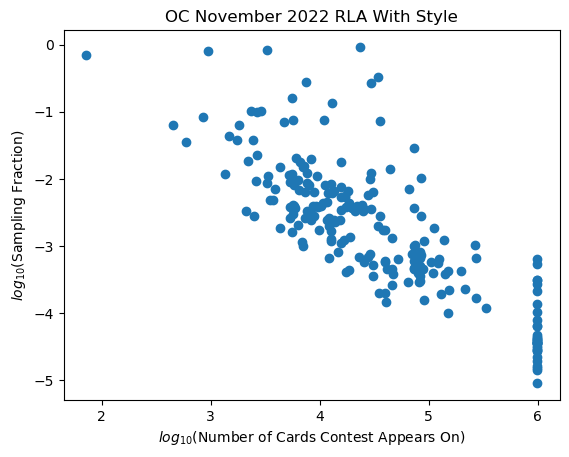

In [23]:
# Plot
plt.scatter(np.log10(contest_cards), np.log10(sampling_fractions))
plt.xlabel("$log_{10}($Number of Cards Contest Appears On$)$")
plt.ylabel("$log_{10}($Sampling Fraction$)$")
plt.title("OC November 2022 RLA With Style")